<a href="https://colab.research.google.com/github/akhilvydyula/Restaurant-Rating-Predict/blob/main/Text_Mining_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [30]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import RegexpTokenizer as regextoken
from nltk.corpus import stopwords
from nltk import FreqDist, bigrams, trigrams
from nltk import WordNetLemmatizer
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
import gensim
from gensim.models.keyedvectors import KeyedVectors
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense, Flatten, Embedding, Conv1D, MaxPooling1D, Dropout, LSTM, GRU
from keras.regularizers import l1, l2
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")

zomato = pd.read_csv("/content/drive/MyDrive/Restaurant /zomato.csv", na_values = ["-", ""])
# Making a copy of the data to work on
data = zomato.copy()

In [5]:
# Dropping duplicates - see Part One for explanation

grouped = data.groupby(["name", "address"]).agg({"listed_in(type)" : list})
newdata = pd.merge(grouped, data, on = (["name", "address"]))
newdata["listed_in(type)_x"] = newdata["listed_in(type)_x"].astype(str) # converting unhashable list to a hashable type
newdata.drop_duplicates(subset = ["name", "address", "listed_in(type)_x"], inplace = True)
newdata = newdata.reset_index(drop = True)

In [6]:
# Transforming the ratings column 

newdata["rating"] = newdata["rate"].str[:3] # Extracting the first three characters of each string in "rate"
# Removing rows with "NEW" in ratings as it is not a predictable level
newdata = newdata[newdata.rating != "NEW"] 
# Dropping rows that have missing values in ratings 
newdata = newdata.dropna(subset = ["rating"])
# Converting ratings to a numeric column so we can discretize it
newdata["rating"] = pd.to_numeric(newdata["rating"])
# Discretizing the ratings into a categorical feature with 4 levels

newdata["rating"] = pd.cut(newdata["rating"], bins = [0, 3.0, 3.5, 4.0, 5.0], labels = ["0", "1", "2", "3"])

Our four rating bins (classes) will be 0 to 3 < 3 to 3.5 < 3.5 to 4 < 4 to 5. To make label encoding easier later, we'll label these classes 0, 1, 2, 3. We can think of these as Very Low, Low, Medium and High.

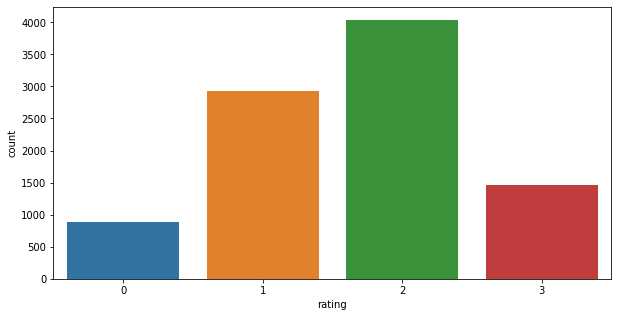

In [7]:
# Visualizing the rating class distribution
plt.figure(figsize = (10, 5))
sns.countplot(newdata["rating"])
plt.show()

In [8]:
# Summary statistics
newdata.describe(include = "all")

,name,address,listed_in(type)_x,url,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type)_y,listed_in(city),rating
count,9316,9316,9316,9316,9316,9316,9316,9316.000000,9149,9316,9279,4577,9313,9284,9316,9316,9316,9316,9316
unique,6512,8676,870,9316,2,2,59,NaN,8381,92,86,4249,2246,63,8964,1990,7,30,4
top,Cafe Coffee Day,Delivery Only,"['Delivery', 'Dine-out']",https://www.zomato.com/bangalore/baisakhi-basa...,Yes,No,3.7/5,NaN,080 43334321,Whitefield,Quick Bites,Biryani,North Indian,400,[],[],Delivery,BTM,2
freq,49,21,872,1,5705,8393,706,NaN,55,617,3445,47,484,1370,332,7314,6519,1115,4037
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,242.149420,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,673.984948,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,191.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Agenda
We will use the reviews_list, menu_item, dish_liked and cuisines columns for our analysis.

First, we will look at the customer reviews and pull out the most common words and phrases. Next, we will analyse cuisine listings and identify cuisines that are rare in Bangalore. Finally we will build a neural network with all four features to predict restaurant ratings.

In [9]:
# Creating a new dataset that has only customer reviews and restaurant ratings
reviews_data = newdata[["reviews_list", "rating"]]
# Examining the reviews for the first restaurant in the dataset
reviews_data["reviews_list"][0]
# The text needs cleaning up

'[(\'Rated 5.0\', "RATED\\n  Had an egg chicken roll and a paneer roll... Really yummy... A must visit place... It would be good if you guys can keep the shop open on Sunday\'s as well.. Good luck... :-)"), (\'Rated 5.0\', \'RATED\\n  Not just the Roll but the filling tastes great. I would highly recommend to others to try their rolls. Owners hospitality is also good and very friendly.\'), (\'Rated 4.5\', \'RATED\\n  Very nice place complete value for money ? Highly recommend.Must visit for any foodie . I would recommend the egg chicken roll . #feeltheroll\'), (\'Rated 5.0\', \'RATED\\n  Had an amazing mouth-watering ?chicken roll?Worth every bite..A must try for every foodie?A variety of rolls and sandwiches are available as well .. A budding rafflesia ?\')]'

In [10]:
# Converting all the text to lowercase
reviews_data["reviews_list"] = reviews_data["reviews_list"].apply(lambda x: x.lower())

# Creating a regular expression tokenizer that matches only alphabets
# This will return separate words (tokens) from the text
tokenizer = regextoken("[a-zA-Z]+") 
# Applying the tokenizer to each row of the reviews
review_tokens = reviews_data["reviews_list"].apply(tokenizer.tokenize)
# Examining the tokens created for the first row / restaurant
print(review_tokens[0])

['rated', 'rated', 'n', 'had', 'an', 'egg', 'chicken', 'roll', 'and', 'a', 'paneer', 'roll', 'really', 'yummy', 'a', 'must', 'visit', 'place', 'it', 'would', 'be', 'good', 'if', 'you', 'guys', 'can', 'keep', 'the', 'shop', 'open', 'on', 'sunday', 's', 'as', 'well', 'good', 'luck', 'rated', 'rated', 'n', 'not', 'just', 'the', 'roll', 'but', 'the', 'filling', 'tastes', 'great', 'i', 'would', 'highly', 'recommend', 'to', 'others', 'to', 'try', 'their', 'rolls', 'owners', 'hospitality', 'is', 'also', 'good', 'and', 'very', 'friendly', 'rated', 'rated', 'n', 'very', 'nice', 'place', 'complete', 'value', 'for', 'money', 'highly', 'recommend', 'must', 'visit', 'for', 'any', 'foodie', 'i', 'would', 'recommend', 'the', 'egg', 'chicken', 'roll', 'feeltheroll', 'rated', 'rated', 'n', 'had', 'an', 'amazing', 'mouth', 'watering', 'chicken', 'roll', 'worth', 'every', 'bite', 'a', 'must', 'try', 'for', 'every', 'foodie', 'a', 'variety', 'of', 'rolls', 'and', 'sandwiches', 'are', 'available', 'as', 'w

In [12]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [14]:
# Importing and examining the English stopwords directory 
# These are common words that typically don't add meaning to the text and can be removed
stop = stopwords.words("english")
print(stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [15]:
# Adding custom words to stopwords 
stop.extend(["rated", "n", "nan", "x"])
# Removing stopwords from the tokens
review_tokens = review_tokens.apply(lambda x: [token for token in x if token not in stop])
# Concatenating all the reviews 
all_reviews = review_tokens.astype(str).str.cat()
cleaned_reviews = tokenizer.tokenize(all_reviews)

# Getting the frequency distribution of individual words in the reviews
fd = FreqDist()
for word in cleaned_reviews:
    fd[word] += 1
    
# Examining the top 5 most frequent words
fd.most_common(5)

[('good', 150929),
 ('food', 147551),
 ('place', 139169),
 ('chicken', 68678),
 ('ordered', 50928)]

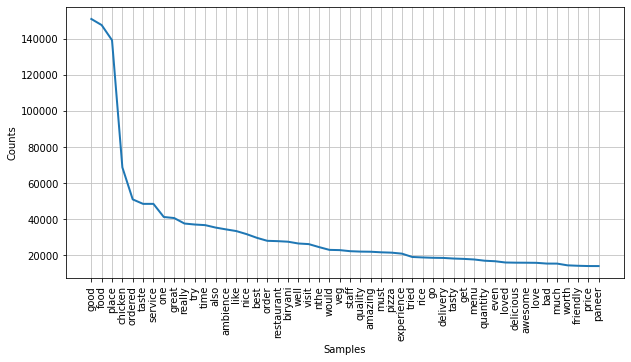

In [16]:
# Plotting the top 50 most frequent words
plt.figure(figsize = (10, 5))
fd.plot(50)
plt.show()

### Observations
Of the 50 most frequent words across customer reviews, six reveal food preferences: **chicken, biryani, veg, pizza, rice, paneer**. The only negative word in the top 50 is "bad".

Factors contributing to restaurant experience are mentioned in the following (descending) order of frequency: place > taste > service > time > ambience > staff > quality > delivery > menu > quantity > friendly.

Now let us repeat the analysis on a bi-gram level. Bi-grams are pairs of words which can provide better context than individual words.

In [17]:
# Generating bigrams from the reviews
bigrams = bigrams(cleaned_reviews)
# Getting the bigram frequency distribution
fd_bigrams = FreqDist()
for bigram in bigrams:
    fd_bigrams[bigram] += 1
# Examining the top 5 most frequent bigrams
fd_bigrams.most_common(5)

[(('must', 'try'), 10719),
 (('really', 'good'), 9973),
 (('good', 'food'), 9939),
 (('food', 'good'), 9585),
 (('good', 'place'), 7871)]

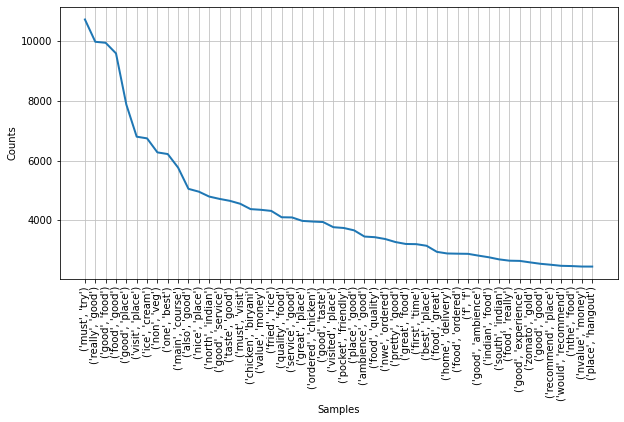

In [18]:
# Plotting the top 50 most frequent bigrams
plt.figure(figsize = (10, 5))
fd_bigrams.plot(50)
plt.show()


### Observations

We have some new insights! Food items/preferences mentioned in the top 50 bigrams are **ice cream, non veg, North Indian, chicken biryani, fried rice, chicken and South Indian**. Top six bigrams related to restaurant experience: good food > good place > good service > value (for) money > pocket friendly > ambience good. 

There's a key insight here: **the expense factor, which was missed by individual word frequency counts, was picked up by the bigram frequency counts.**

Zomato might also be happy to know their membership program "Zomato Gold" is in the top 50 bigrams, with 2593 mentions in the customer reviews.

What about trigrams? 

In [19]:
# Generating trigrams from the reviews
trigrams = trigrams(cleaned_reviews)

fd_trigrams = FreqDist()
for trigram in trigrams:
    fd_trigrams[trigram] += 1

fd_trigrams.most_common(5)

[(('xa', 'xa', 'xa'), 1975),
 (('north', 'indian', 'food'), 1707),
 (('f', 'f', 'f'), 1681),
 (('must', 'visit', 'place'), 1666),
 (('veg', 'non', 'veg'), 1634)]

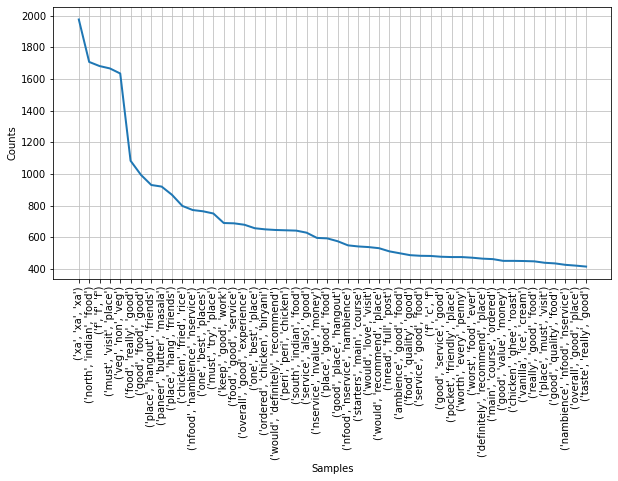

In [20]:
plt.figure(figsize = (10, 5))
fd_trigrams.plot(50)
plt.show()

### Observations
There appears to be some bad data (strings of "xa xa xa") somewhere in the reviews, but we'll ignore that. The specific food preferences we can see here are **paneer butter masala, chicken fried rice, chicken biryani, peri peri chicken and chicken ghee roast**. Bangalore is really into chicken.

On restaurant experience: a specific insight revealed by the trigrams is that **many people are looking for places to hang out with their friends**. 

We also see a variety of positive trigrams like "must visit place", "food really good", "service also good" and "worth every penny". However, there is only one negative trigram in the top 50 - "worst food ever".

We now have plenty of insights into customer preferences and experiences, and will move onto an analysis of Bangalore's cuisines.

In [21]:
# Creating a new dataset with cuisines info and restaurant ratings
cuisines = newdata[["cuisines", "rating"]]
cuisines["cuisines"] = cuisines["cuisines"].astype(str)
# Converting to lowercase
cuisines["cuisines"] = cuisines["cuisines"].apply(lambda x: x.lower())
# Tokenizing the cuisines
cuisine_tokens = cuisines["cuisines"].apply(tokenizer.tokenize)
# Concatenating all the cuisine names into one text document
all_cuisines = cuisine_tokens.astype(str).str.cat()
cleaned_cuisines = tokenizer.tokenize(all_cuisines)

# Generating cuisine frequencies 
fd_cuisine = FreqDist()
for cuisine in cleaned_cuisines:
    fd_cuisine[cuisine] += 1
    
# Printing the 50 most common cuisines (top 50)
print(fd_cuisine.most_common(50))

[('indian', 5506), ('north', 3860), ('chinese', 2836), ('food', 2512), ('south', 1633), ('fast', 1602), ('biryani', 1285), ('desserts', 985), ('beverages', 842), ('continental', 821), ('cafe', 674), ('street', 605), ('italian', 501), ('bakery', 495), ('pizza', 393), ('andhra', 379), ('ice', 374), ('cream', 374), ('burger', 369), ('seafood', 320), ('mughlai', 305), ('rolls', 297), ('momos', 246), ('kerala', 244), ('mithai', 206), ('juices', 202), ('american', 200), ('arabian', 193), ('thai', 185), ('asian', 183), ('salad', 179), ('kebab', 174), ('sandwich', 167), ('finger', 159), ('healthy', 145), ('bbq', 126), ('mangalorean', 111), ('bengali', 106), ('european', 104), ('mexican', 98), ('mediterranean', 86), ('steak', 75), ('hyderabadi', 69), ('tea', 68), ('tibetan', 54), ('japanese', 43), ('chettinad', 38), ('chicken', 32), ('vietnamese', 31), ('rajasthani', 29)]


### Observations
One must be careful when interpreting these lists. For example, "dogs" can't be a cuisine but the preceding word "hot" tells us that the cuisine is "hot dogs". Another tricky one is Cantonese, which comes under Chinese and so might not really be rare.

We've done our reviews and cuisines analysis and will now prepare all the text in the dataset for feeding into a neural network.

## Text Preprocessing

In [22]:
# Converting all the text to strings
newdata[["reviews_list", "menu_item", "dish_liked", "cuisines"]] = newdata[["reviews_list", "menu_item", "dish_liked", "cuisines"]].astype("str")
# Combining all the text data into a single feature called "text"
newdata["text"] = newdata["reviews_list"] + " " + newdata["menu_item"] + " " + newdata["dish_liked"] + " " + newdata["cuisines"]
# Creating a new dataset with text and restaurant ratings
text_data = newdata[["text", "rating"]]
# Converting text to lowercase
text_data["text"] = text_data["text"].apply(lambda x: x.lower())
# Tokenizing the text
tokens = text_data["text"].apply(tokenizer.tokenize) 
# Removing stopwords 
tokens = tokens.apply(lambda x: [token for token in x if token not in stop])


In [23]:
print(tokens[0])

['egg', 'chicken', 'roll', 'paneer', 'roll', 'really', 'yummy', 'must', 'visit', 'place', 'would', 'good', 'guys', 'keep', 'shop', 'open', 'sunday', 'well', 'good', 'luck', 'roll', 'filling', 'tastes', 'great', 'would', 'highly', 'recommend', 'others', 'try', 'rolls', 'owners', 'hospitality', 'also', 'good', 'friendly', 'nice', 'place', 'complete', 'value', 'money', 'highly', 'recommend', 'must', 'visit', 'foodie', 'would', 'recommend', 'egg', 'chicken', 'roll', 'feeltheroll', 'amazing', 'mouth', 'watering', 'chicken', 'roll', 'worth', 'every', 'bite', 'must', 'try', 'every', 'foodie', 'variety', 'rolls', 'sandwiches', 'available', 'well', 'budding', 'rafflesia', 'fast', 'food']


In [25]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [27]:
# Writing a function to lemmatize words
lmtzr = WordNetLemmatizer()
def lem(text):
    return [lmtzr.lemmatize(word) for word in text]

# Applying the function to each row of the text
# i.e. reducing each word to its lemma
tokens_new = tokens.apply(lem)

In [31]:
# Applying label encoding and one hot encoding to the restaurant rating classes 
le = LabelEncoder()
target = le.fit_transform(text_data["rating"])
target = to_categorical(target)

In [32]:
# Splitting the data into train and test sets (stratified)
X_train, X_test, y_train, y_test = train_test_split(tokens_new, target, test_size = 0.3, random_state = 0, stratify = target)

# Processing the text with the Keras tokenizer
t = Tokenizer() 
t.fit_on_texts(X_train)
# Setting a vocabulary size that we will specify in the neural network
vocab_size = len(t.word_index) + 1
# The t.word_index contains each unique word in our text and an integer assigned to it
print(vocab_size)

46123


In [33]:
# Encoding the text as sequences of integers
train_sequences = t.texts_to_sequences(X_train)
test_sequences = t.texts_to_sequences(X_test)
# Adding zeros so each sequence has the same length 
train_padded = pad_sequences(train_sequences, maxlen=500)
test_padded = pad_sequences(test_sequences, maxlen=500)

brew install wget

wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
This downloads the GZIP compressed file that you can uncompress using:

gzip -d GoogleNews-vectors-negative300.bin.gz
You can then use the below command to get wordVector.

from gensim import models

w = models.KeyedVectors.load_word2vec_format(
    '../GoogleNews-vectors-negative300.bin', binary=True)

In [35]:
!wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz" 

--2021-08-09 13:11:12--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.172.72
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.172.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  72.5MB/s    in 25s     

2021-08-09 13:11:37 (62.5 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [41]:
!gzip -d GoogleNews-vectors-negative300.bin.gz

In [43]:
!ls

drive  GoogleNews-vectors-negative300.bin  sample_data


In [45]:
# Loading Word2Vec word embeddings 

word_vectors = KeyedVectors.load_word2vec_format( 'GoogleNews-vectors-negative300.bin', binary=True)

embedding_dim = 300 # each word will become a 300-d vector

# Creating an empty matrix 
embedding_matrix = np.zeros((vocab_size, embedding_dim)) 
# Each row is a word with 300 dimensions

# Populating the matrix
for word, i in t.word_index.items(): # for each word in the customer reviews vocabulary
    try:
        # get the Word2Vec vector representation for that word
        embedding_vector = word_vectors[word] 
        # add it to the embedding matrix
        embedding_matrix[i] = embedding_vector 
        # handle new words by generating random vectors for them
    except KeyError: 
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25), embedding_dim)

In [46]:
embedding_matrix.shape

(46123, 300)

In [47]:
# Examining the words embeddings - vector representations of words
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.18164062,  0.16503906, -0.16601562, ...,  0.15917969,
         0.12792969,  0.00222778],
       [ 0.04052734,  0.0625    , -0.01745605, ..., -0.15625   ,
         0.00193024, -0.06982422],
       ...,
       [-0.12304688, -0.23925781,  0.25976562, ...,  0.06201172,
         0.14746094,  0.12011719],
       [-0.07362568, -0.33642301, -0.62491573, ..., -0.01554796,
        -0.27020695, -0.8823394 ],
       [-0.23801336, -0.14618539, -0.34087492, ...,  0.40586642,
         0.35753403, -0.12258468]])

## Model Building

In [49]:
# Building an LSTM neural network

warnings.filterwarnings("ignore")
max_length = 50 # maximum length of each input string (movie review)

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length, weights = [embedding_matrix], trainable = False))
model.add(LSTM(100, activation = "tanh"))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer = "adam", metrics=['accuracy'])
model.fit(train_padded, y_train, validation_data=(test_padded, y_test), epochs=3, batch_size=256)

Epoch 1/3
26/26 [==============================] - 84s 3s/step - loss: 1.2461 - accuracy: 0.4307 - val_loss: 1.0684 - val_accuracy: 0.5267
Epoch 2/3
26/26 [==============================] - 82s 3s/step - loss: 1.0601 - accuracy: 0.5152 - val_loss: 1.0126 - val_accuracy: 0.5621
Epoch 3/3
26/26 [==============================] - 82s 3s/step - loss: 1.0024 - accuracy: 0.5548 - val_loss: 0.9915 - val_accuracy: 0.5621


### Evaluation

In [50]:
# Predicting on the train data
pred_train = model.predict(train_padded)
pred_train = np.argmax(pred_train, axis=1)
y_train = np.argmax(y_train, axis=1)
# Printing evaluation metrics
print(classification_report(y_train, pred_train))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       619
           1       0.58      0.62      0.60      2050
           2       0.56      0.64      0.59      2826
           3       0.62      0.66      0.64      1026

    accuracy                           0.57      6521
   macro avg       0.44      0.48      0.46      6521
weighted avg       0.52      0.57      0.55      6521



In [51]:
# Predicting on the test data
pred_test = model.predict(test_padded)
pred_test = np.argmax(pred_test, axis=1)
y_test = np.argmax(y_test, axis = 1)
# Printing evaluation metrics
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       265
           1       0.55      0.63      0.59       879
           2       0.55      0.61      0.58      1211
           3       0.61      0.64      0.63       440

    accuracy                           0.56      2795
   macro avg       0.43      0.47      0.45      2795
weighted avg       0.51      0.56      0.53      2795

